# 🧸🏰 **Toy dataset binary classification** 🪁🦄

chapter 2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**PyTorch Neural Network Classification**

video:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://www.youtube.com/watch?v=Z_ikDlimN6A

simulation:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://playground.tensorflow.org

# Imports

In [1]:
import torch
import sklearn
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from sklearn.datasets import make_circles

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.12.1+cu113


# Data Preparation

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(
f'''
Length of X: {len(X)}
Length of y: {len(y)}
'''
)


Length of X: 1000
Length of y: 1000



# Data Visualization

In [3]:
# “Beauty will save the world” - Dostoevsky
def centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])

In [4]:
# Creates pandas dataframe
circles = pd.DataFrame({
    "X1": X[:, 0], 
    "X2": X[:, 1],
    "label": y
})

display(centered(circles.head(10)))

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
display(centered(circles.describe()))

,X1,X2,label
count,1000.000000,1000.000000,1000.000000
mean,-0.000448,-0.000804,0.500000
std,0.639837,0.641156,0.500250
min,-1.059502,-1.067768,0.000000
25%,-0.619251,-0.612176,0.000000
50%,0.008762,-0.003949,0.500000
75%,0.621933,0.624822,1.000000
max,1.033712,1.036004,1.000000


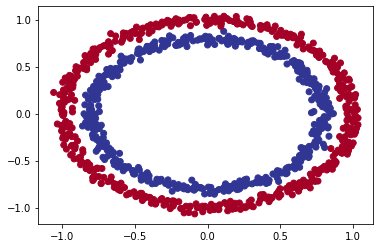

In [6]:
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
);

# Data Compatibility

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(
f'''
Sample of X: {X_sample}
Shape of X: {X.shape}

Sample of y: {y_sample}
Shape of y: {y.shape}

Class: {type(X)}
DataType: {X.dtype}
'''
)


Sample of X: [0.75424625 0.23148074]
Shape of X: (1000, 2)

Sample of y: 1
Shape of y: (1000,)

Class: <class 'numpy.ndarray'>
DataType: float64



In [8]:
# Turn numpy data into tensors
# PyTorch uses Float32 while Numpy uses Float64
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

print(
f'''
Sample of X:
{X[:5]}

Sample of y:
{y[:5]}

Class: {type(X)}
DataType: {X.dtype}
'''
)


Sample of X:
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

Sample of y:
tensor([1., 1., 1., 1., 0.])

Class: <class 'torch.Tensor'>
DataType: torch.float32



# Splitting train/test

In [9]:
# 80% training - 20% test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

print(
f'''
Length of X_train: {len(X_train)}
Length of y_train: {len(y_train)}

Length of X_test: {len(X_test)}
Length of y_test: {len(y_test)}
'''
)


Length of X_train: 800
Length of y_train: 800

Length of X_test: 200
Length of y_test: 200



# model building

In [10]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [11]:
# model implementation
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1) 

  def forward(self, x): # x -> layer_1 ->  layer_2 -> output
    return self.layer_2(self.layer_1(x))

In [12]:
# Create model instance and sent it do device
linear_model = LinearModel().to(device)

# The same model can also be defined like this
linear_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

print(f'''{linear_model} device: {next(linear_model.parameters()).device}''')

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
) device: cpu


# Predictions with untrained model

In [13]:
# Calculate accuracy - % of right predictions
def accuracy_fn(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item() 
  acc = (correct/len(y_pred)) * 100
  return acc

In [14]:
# Make predictions
linear_model.eval()
with torch.inference_mode():
    untrained_preds = linear_model(X_test.to(device))

print(
f'''
Length of predictions: {len(untrained_preds)} 
Shape of predictions: {untrained_preds.shape}

Length of test samples: {len(X_test)}
Shape of test samples: {X_test.shape}

First 10 predictions:
{torch.abs(torch.round(untrained_preds.squeeze()[:10]))}

First 10 labels:
{y_test[:10]}

accuracy: {accuracy_fn(untrained_preds, y_test)}
'''
)


Length of predictions: 200 
Shape of predictions: torch.Size([200, 1])

Length of test samples: 200
Shape of test samples: torch.Size([200, 2])

First 10 predictions:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

accuracy: 0.0



# Model Training

Note: `loss = nn.BCELoss(y_probs, y_train)` is less numerically stable than `loss = nn.BCEWithLogitsLoss(y_logits, y_train)`

In [15]:
# Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42) 

# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer
optimizer = torch.optim.SGD(params=linear_model.parameters(), lr=0.1)

# Set the number of epochs
epochs = 100

# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training and evaluation loop
for epoch in range(epochs + 1):
    linear_model.train()

    # 1. Forward pass
    y_logits = linear_model(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_probs) 

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step() 

    ### Testing
    linear_model.eval()
    with torch.inference_mode():
        # 1. Forward pass 
        test_logits = linear_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
  
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

Epoch: 0 | Loss: 0.69937, Acc: 50.00% | Test loss: 0.69881, Test acc: 50.00%

Epoch: 10 | Loss: 0.69542, Acc: 51.12% | Test loss: 0.69581, Test acc: 54.50%

Epoch: 20 | Loss: 0.69424, Acc: 52.62% | Test loss: 0.69498, Test acc: 54.00%

Epoch: 30 | Loss: 0.69384, Acc: 51.62% | Test loss: 0.69470, Test acc: 51.50%

Epoch: 40 | Loss: 0.69366, Acc: 50.75% | Test loss: 0.69458, Test acc: 50.50%

Epoch: 50 | Loss: 0.69356, Acc: 50.62% | Test loss: 0.69449, Test acc: 50.50%

Epoch: 60 | Loss: 0.69348, Acc: 50.25% | Test loss: 0.69442, Test acc: 52.00%

Epoch: 70 | Loss: 0.69342, Acc: 50.25% | Test loss: 0.69437, Test acc: 52.00%

Epoch: 80 | Loss: 0.69337, Acc: 50.12% | Test loss: 0.69432, Test acc: 51.00%

Epoch: 90 | Loss: 0.69332, Acc: 50.38% | Test loss: 0.69429, Test acc: 50.00%

Epoch: 100 | Loss: 0.69328, Acc: 50.50% | Test loss: 0.69426, Test acc: 50.00%



# Predictions with trained model

In [16]:
# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
URL = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get(URL)
  with open("helper_functions.py", "wb") as f: f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


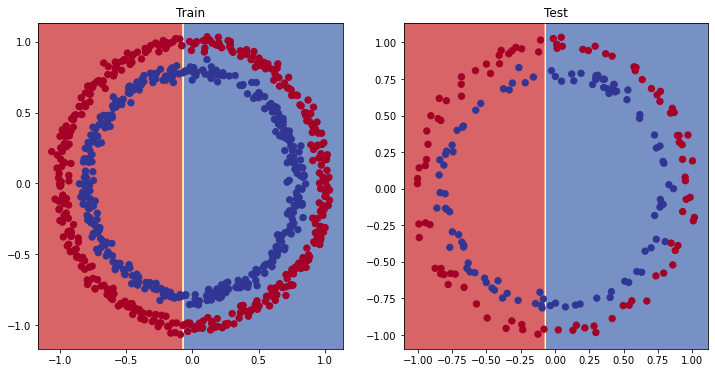

In [17]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(linear_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(linear_model, X_test, y_test) 

# Nonliner Model


In [18]:
# Model implementation
from torch import nn
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function
    
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [19]:
# Create model instance and sent it do device
model = CircleModel().to(device)

# The same model can also be defined like this
model = nn.Sequential(
    nn.Linear(2,10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,1),
).to(device)

print(f'''{model} device: {next(model.parameters()).device}''')

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
) device: cpu


# Nonlinear model training

In [20]:
# Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set the number of epochs
epochs = 5000

# Training and evaluation loop
for epoch in range(epochs + 1):
    model.train()

    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_probs) 

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step() 

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test)
  
  # Print out what's this happenin'
    if epoch % 250 == 0:
        print(f"Epoch: {epoch}   |   Loss: {loss:.4f}, Acc: {acc:.2f}%   |   Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")

Epoch: 0   |   Loss: 0.6944, Acc: 50.00%   |   Test Loss: 0.6936, Test Acc: 50.00%

Epoch: 250   |   Loss: 0.6903, Acc: 51.12%   |   Test Loss: 0.6885, Test Acc: 55.00%

Epoch: 500   |   Loss: 0.6873, Acc: 52.00%   |   Test Loss: 0.6844, Test Acc: 56.00%

Epoch: 750   |   Loss: 0.6825, Acc: 58.25%   |   Test Loss: 0.6790, Test Acc: 59.50%

Epoch: 1000   |   Loss: 0.6730, Acc: 59.62%   |   Test Loss: 0.6707, Test Acc: 59.50%

Epoch: 1250   |   Loss: 0.6482, Acc: 66.12%   |   Test Loss: 0.6512, Test Acc: 66.50%

Epoch: 1500   |   Loss: 0.5477, Acc: 90.00%   |   Test Loss: 0.5664, Test Acc: 85.00%

Epoch: 1750   |   Loss: 0.2641, Acc: 99.75%   |   Test Loss: 0.2976, Test Acc: 99.00%

Epoch: 2000   |   Loss: 0.1065, Acc: 99.88%   |   Test Loss: 0.1410, Test Acc: 99.50%

Epoch: 2250   |   Loss: 0.0520, Acc: 99.75%   |   Test Loss: 0.0809, Test Acc: 99.50%

Epoch: 2500   |   Loss: 0.0318, Acc: 99.75%   |   Test Loss: 0.0563, Test Acc: 99.50%

Epoch: 2750   |   Loss: 0.0224, Acc: 100.00%   | 

# Model Evaluation

In [21]:
# Makes predictions
model.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()

print(
f'''
Length of predictions: {len(y_preds)} 
Shape of predictions: {y_preds.shape}

Length of test samples: {len(X_test)}
Shape of test samples: {X_test.shape}

First 10 predictions:
{torch.abs(torch.round(y_preds.squeeze()[:10]))}

First 10 labels:
{y_test[:10]}

accuracy: {accuracy_fn(y_preds, y_test)}
'''
)


Length of predictions: 200 
Shape of predictions: torch.Size([200])

Length of test samples: 200
Shape of test samples: torch.Size([200, 2])

First 10 predictions:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

accuracy: 99.0



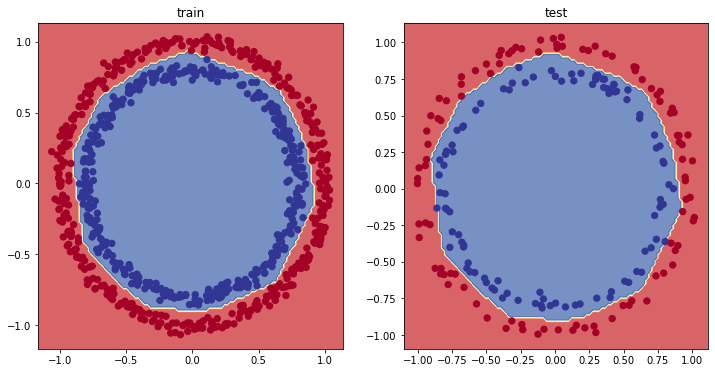

In [22]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model, X_train, y_train) 

plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model, X_test, y_test)

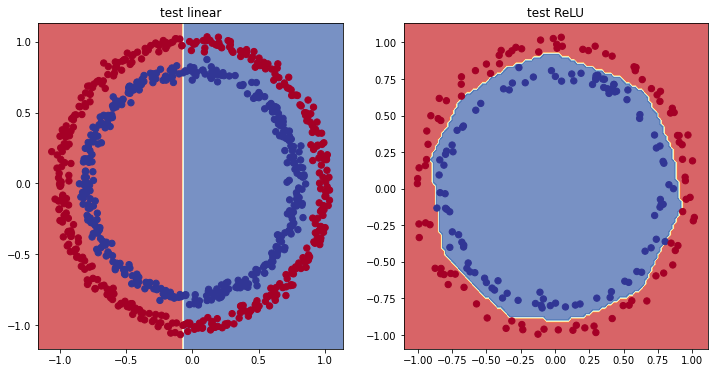

In [23]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("test linear")
plot_decision_boundary(linear_model, X_train, y_train) 

plt.subplot(1, 2, 2)
plt.title("test ReLU")
plot_decision_boundary(model, X_test, y_test)